# House Price Predictions

We are given a dataset in csv format consisting of prices of homes sold in various locations. The prices depend on certain parameters and the task is to predict prices of homes with similar characteristics. Thus, we have a problem of regression. Let us take a look at the data:

In [1]:
#Loading essential libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='darkgrid')

#Loading the csv file into a dataframe

df = pd.read_csv('house_sales.csv')

df.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,221900,3,1.00,1180,5650,1.0,0,3,0,1955,0,98178,47.511234,-122.256775,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,3,400,1951,1991,98125,47.721023,-122.318862,1690,7639
2,180000,2,1.00,770,10000,1.0,0,3,0,1933,0,98028,47.737927,-122.233196,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,5,910,1965,0,98136,47.520820,-122.393185,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,3,0,1987,0,98074,47.616812,-122.044901,1800,7503


In [2]:
#Shape of the dataset
print(df.shape)

#Checking if there is any missing data
print(df.isnull().any())

#Name of the columns
print(df.columns.tolist())

(18448, 16)
price                       False
num_bed                     False
num_bath                    False
size_house                  False
size_lot                    False
num_floors                  False
is_waterfront               False
condition                   False
size_basement               False
year_built                  False
renovation_date             False
zip                         False
latitude                    False
longitude                   False
avg_size_neighbor_houses    False
avg_size_neighbor_lot       False
dtype: bool
['price', 'num_bed', 'num_bath', 'size_house', 'size_lot', 'num_floors', 'is_waterfront', 'condition', 'size_basement', 'year_built', 'renovation_date', 'zip', 'latitude', 'longitude', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot']


So, there are 18448 rows and 16 columns in the dataset. There is no missing entry. The columns (or variables) are as follows:

'price', 'num_bed', 'num_bath', 'size_house', 'size_lot', 'num_floors', 'is_waterfront', 'condition', 'size_basement', 'year_built', 'renovation_date', 'zip', 'latitude', 'longitude', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot'

The first thing we can observe is that the location given in terms of longitudes and latitudes have 6 digits after decimal. It is natural to ask if such an accuracy of location can have much effect on prices. I would tend to round it off to 2 digits. Observe that by doing this, a .01 difference between longitude or latitude of two locations seperates them by 1 kilometer. Since the zipcodes are also given, I tend to believe that the correlation between the size_house given a zipcode with the price must be higher. We will check that later!

In [3]:
#Rounding off the longitudes and latitudes to two decimal points
df['latitude'] = df['latitude'].map(lambda x : round(x,2))
df['longitude'] = df['longitude'].map(lambda x: round(x,2))

df.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,size_basement,year_built,renovation_date,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,221900,3,1.00,1180,5650,1.0,0,3,0,1955,0,98178,47.51,-122.26,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,3,400,1951,1991,98125,47.72,-122.32,1690,7639
2,180000,2,1.00,770,10000,1.0,0,3,0,1933,0,98028,47.74,-122.23,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,5,910,1965,0,98136,47.52,-122.39,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,3,0,1987,0,98074,47.62,-122.04,1800,7503


Let us check the correlation coefficients between all the variables.

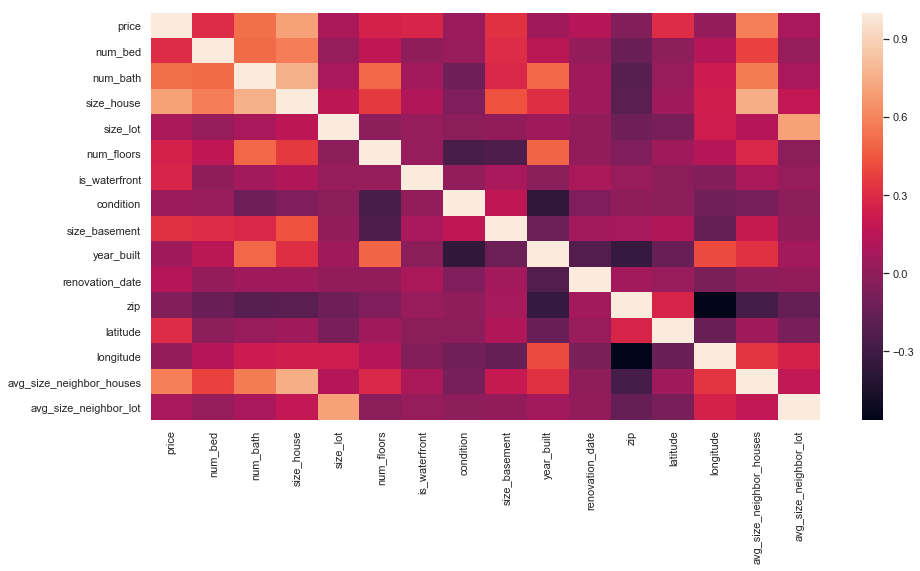

In [4]:
corr_coeff = df.corr()
plt.figure(figsize=(15,7.5))
sns.heatmap(corr_coeff)

The correlation coefficients suggest that size_house and avg_size_neighbor_house are highly correlated with the price, num_bed, num_bath come in second, while longitude, latitude and zip are least correlated with the prices. This was expected. Let see the correlation of house_size given a zipcode with the price. We randomly choose one zip code for this purpose.

In [5]:
corr = df['price'].where(df['zip'] == 98136).corr(df['size_house'].where(df['zip'] == 98136))
corr

0.7407540814791669

As expected!!

Notice that except 'size_home' , 'size_lot', 'avg_size_neighbor_houses', 'avg_size_neighbor_lot' and 'year_built', all other variables are categorical variables. Thus our problem involves both numerical and categorical variables. This already suggest that ensemble based methods would be useful for regression. 

Next, observe that 4 out of 5 'renovation_date' entries are 0. Let us check how many of the rows have non-zero renovation_date entry.

In [6]:
#How many unique renovation_date entries are there?
df['renovation_date'].where(df['renovation_date'] != 0).nunique()

67

Only 67 out of 18448 rows have non zero renovation_date entry. It seems unlikely that renovation_date would have much affect on the prices. 

What about size_basement?

In [7]:
#How many unique size_basement entries are there?
df['size_basement'].where(df['size_basement'] != 0).nunique()

282

The column of size_basement also seem unlikely to have much affect on the price prediction. We will drop these two columns from our dataset.

In [8]:
#Dropping renovation_date and size_basement
df = df.drop(columns = ['renovation_date','size_basement'])
df.head()

,price,num_bed,num_bath,size_house,size_lot,num_floors,is_waterfront,condition,year_built,zip,latitude,longitude,avg_size_neighbor_houses,avg_size_neighbor_lot
0,221900,3,1.00,1180,5650,1.0,0,3,1955,98178,47.51,-122.26,1340,5650
1,538000,3,2.25,2570,7242,2.0,0,3,1951,98125,47.72,-122.32,1690,7639
2,180000,2,1.00,770,10000,1.0,0,3,1933,98028,47.74,-122.23,2720,8062
3,604000,4,3.00,1960,5000,1.0,0,5,1965,98136,47.52,-122.39,1360,5000
4,510000,3,2.00,1680,8080,1.0,0,3,1987,98074,47.62,-122.04,1800,7503


Here are some more general obervations:

In [9]:
# Number of Unique values in various categorical variables

print("num_bed: {}".format(df['num_bed'].nunique()))
print("num_bath: {}".format(df['num_bath'].nunique()))
print("num_floors: {}".format(df['num_floors'].nunique()))
print("is_waterfront: {}".format(df['is_waterfront'].nunique()))
print("condition: {}".format(df['condition'].nunique()))
print("year_built: {}".format(df['year_built'].nunique()))
print("zip: {}".format(df['zip'].nunique()))

num_bed: 12
num_bath: 30
num_floors: 6
is_waterfront: 2
condition: 5
year_built: 116
zip: 70


Let us now draw some figures and check for outliers. 

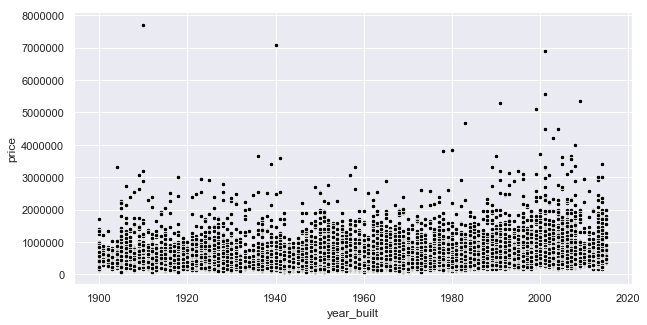

In [10]:
#Price vs. Year_built
plt.figure(figsize=(10,5))
sns.scatterplot(df['year_built'],df['price'],color = 'black',s = 20)

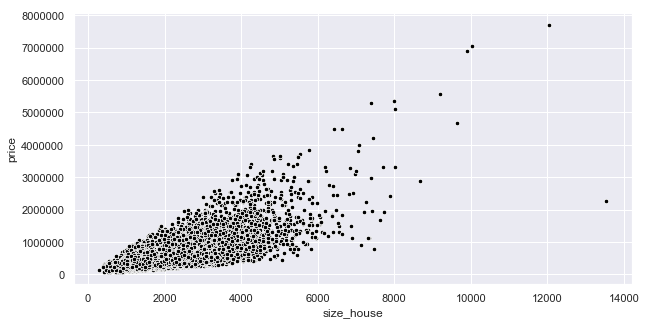

In [11]:
#Price vs. House size
plt.figure(figsize=(10,5))
sns.scatterplot(df['size_house'],df['price'],color = 'black',s = 20)

# Added on Nov 7

We want to check the distribution of the sale prices. Check for skewness and try to correct it.

542362.3713139636 372003.4361424682
4.115431987666006


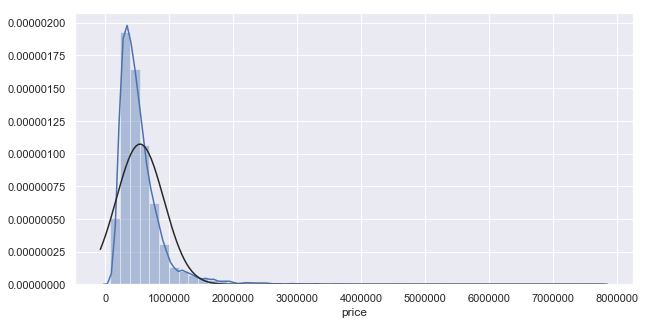

In [22]:
from scipy.stats import norm, skew
from scipy import stats
plt.figure(figsize=(10,5))
sns.distplot(df['price'],fit = norm)
(mu,sigma)=norm.fit(df['price'])
print(mu,sigma)
print(stats.skew(df['price']))

Price is right-skewed. We could perhaps use log-transformation for a better fit.
+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

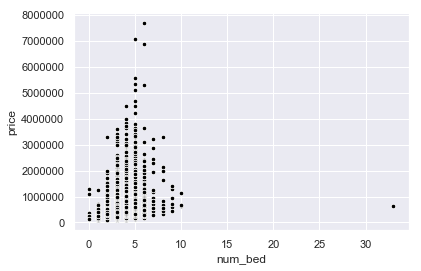

In [93]:
#Price vs. Num_bed
sns.scatterplot(df['num_bed'],df['price'],color = 'black',s = 20)

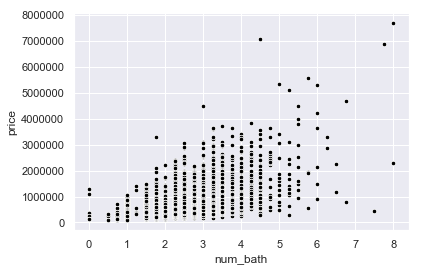

In [94]:
#Price vs. num_bath
sns.scatterplot(df['num_bath'],df['price'],color = 'black',s = 20)

## Linear regressor

The figures above suggest that there are entries with ridiculous values. I would tend to only restrict to homes whose price is below 5000000, and size_house is below 8000. We must also remove the entry with num_bed more than 30. 

But, before removing the outliers let us use simple linear regression to predict the prices given size_homes. We will do this to compare the results after removing outliers.

In [95]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = .25)

In [96]:
# Checking the head and shape of train and test data
print(df_train.head())
print(df_test.head())
print(df_train.shape)
print(df_test.shape)

         price  num_bed  num_bath  size_house  size_lot  num_floors  \
14208   552321        3      2.50        1960      8469         2.0   
14092  1400000        5      4.00        4700     22326         2.0   
13972   189000        3      1.00        1380      7282         1.5   
17617   779380        5      2.50        2590      7084         2.0   
906     318000        3      2.25        1410      8909         2.0   

       is_waterfront  condition  year_built    zip  latitude  longitude  \
14208              0          4        1984  98052     47.72    -122.11   
14092              0          3        2002  98006     47.54    -122.11   
13972              0          5        1915  98002     47.30    -122.22   
17617              0          3        2014  98052     47.71    -122.11   
906                0          3        1988  98198     47.40    -122.31   

       avg_size_neighbor_houses  avg_size_neighbor_lot  
14208                      2040                   8189  
14092   

In [97]:
#Linear regression for price vs. size_home
from sklearn.linear_model import LinearRegression
base_model = LinearRegression().fit(df_train[['size_house']],df_train['price'])

In [98]:
#Fitted regression line coefficients
print(base_model.coef_,base_model.intercept_)

[282.07749316] -46444.41747147485


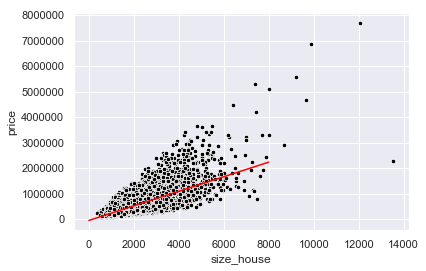

In [99]:
#Plotting regression line
X = range(0,8000)
Y = [285.82384124*item - 53879.01331859024 for item in X]
sns.scatterplot(df_train['size_house'],df_train['price'],color='black',s=20)
sns.lineplot(X,Y,color = 'red')


Let us calculate the root mean squared error (we will simply take the square root of the mean squared error) of the linear model. We will calculate it with other models later.

In [100]:
import numpy as np
base_model_predictions = base_model.predict(df_test[['size_house']])
from sklearn.metrics import mean_squared_error
base_model_error = np.sqrt(mean_squared_error(df_test['price'],base_model_predictions))
base_model_error

272778.2804890402

## Added on November 5

Let us use Adaboosting to boost the linear regressor and check the error.

In [101]:
from sklearn.ensemble import AdaBoostRegressor

boost_reg = AdaBoostRegressor(LinearRegression()).fit(df_train[['size_house']],df_train['price'])

In [102]:
boost_reg_pred = boost_reg.predict(df_test[['size_house']])
boost_reg_error = np.sqrt(mean_squared_error(df_test['price'],boost_reg_pred))
boost_reg_error

300562.2967519826

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

So, the root mean squared error is 265061. But, this is expected as the prices range between some hundred thousands to millions. Let us remove the possible outliers. I do not hope that this will make much difference in the simple model.

In [103]:
df = df.drop(df[df['price'] > 3000000].index)

In [104]:
df = df.drop(df[df.size_house > 7000].index)

In [105]:
df = df.drop(df[df.num_bed > 10].index)

In [106]:
df.shape

(18393, 14)

In [107]:
#New test and train split

df_train2, df_test2 = train_test_split(df, test_size = .33)

## Decision tree regressor

Let us now use tree based regressors to accomodate also the categorical variable. We will use decision tree and random forest classifiers. The most significant variables as appeared in the correlation matrix.

In [108]:
from sklearn.tree import DecisionTreeRegressor

dtreereg = DecisionTreeRegressor(max_depth=9,random_state=10).fit(df_train2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'num_floors', 'is_waterfront', 'condition','zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']],df_train2['price'])

In [109]:
#predictions of decision tree regressors

dtree_pred = dtreereg.predict(df_test2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'num_floors', 'is_waterfront', 'condition','zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']])

In [110]:
print(dtree_pred[0:10])

[356672.33333333 376401.6991404  376401.6991404  460793.28604924
 530179.27887789 941563.390625   661722.84558824 460793.28604924
 460793.28604924 791815.30612245]


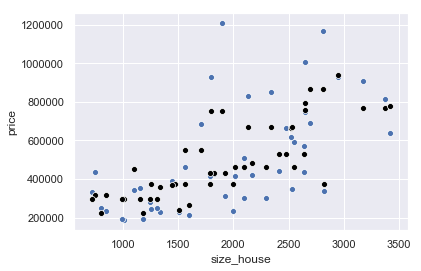

In [111]:
sns.scatterplot(df_test2['size_house'][0:50],df_test2['price'][0:50])
sns.scatterplot(df_test2['size_house'][0:50],dtree_pred[0:50],color = 'black')

The predictions are still quite off the true values. We could be overfitting since there are just too many variables with low correlation with the prices. Let us calculate the error using root mean squared error (We will simply take the square root of the mean squared error).

In [112]:
error_dtree = mean_squared_error(df_test2['price'],dtree_pred)
np.sqrt(error_dtree)

197143.10833472796

In [114]:
print(dtreereg.max_features_)
print(dtreereg.feature_importances_)

10
[0.00445845 0.00805565 0.63852835 0.0100412  0.00686916 0.03492431
 0.00234934 0.17633542 0.08132116 0.03711695]


## Added on Nov 5

Adaboosting applied to decision tree regressor

In [33]:
dtreeboostreg = AdaBoostRegressor(DecisionTreeRegressor(max_depth=9,random_state=10)).fit(df_train2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'num_floors', 'is_waterfront', 'condition','zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']],df_train2['price'])

In [115]:
dtreeboostreg_pred = dtreeboostreg.predict(df_test2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'num_floors', 'is_waterfront', 'condition','zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']])

In [118]:
error_dtreeboost = mean_squared_error(df_test2['price'],dtreeboostreg_pred)
np.sqrt(error_dtreeboost)

128756.13124856586

+++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

So the decision tree regressor has performed slightly better than the linear regressor.

## Random Forest regressor

In [119]:
from sklearn.ensemble import RandomForestRegressor

In [120]:
#To avoid overfitting we will remove some statistically insignificant variable. 
#This include condition, year built and number of floors.

RFreg = RandomForestRegressor(n_estimators=500).fit(df_train2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']], df_train2['price'])

In [121]:
#Random Forest prediction

RF_pred = RFreg.predict(df_test2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']])
RF_pred

array([301219.418     , 397524.004     , 485553.24933333, ...,
       286221.164     , 720727.524     , 300707.744     ])

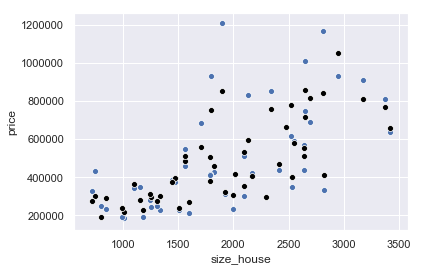

In [122]:
#Plotting the predictions
sns.scatterplot(df_test2['size_house'][0:50],df_test2['price'][0:50])
sns.scatterplot(df_test2['size_house'][0:50],RF_pred[0:50],color = 'black')

The plot suggests that we have improved predictions.

In [123]:
#Error (root mean squared)
error_RF = mean_squared_error(df_test2['price'],RF_pred)
np.sqrt(error_RF)

149890.9208795532

# Added on November 5

In [124]:
# Averaging Decision Tree and Random Forest

Avg_pred = (RF_pred + dtree_pred)/2
Avg_pred

array([328945.87566667, 386962.8515702 , 430977.47423687, ...,
       279032.76983069, 590760.40502462, 298510.80022026])

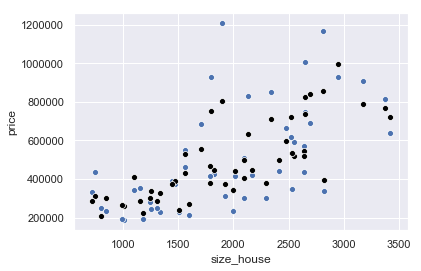

In [125]:
#Plotting the predictions
sns.scatterplot(df_test2['size_house'][0:50],df_test2['price'][0:50])
sns.scatterplot(df_test2['size_house'][0:50],Avg_pred[0:50],color = 'black')

In [126]:
#Error (root mean squared)
error_Avg = mean_squared_error(df_test2['price'],Avg_pred)
np.sqrt(error_Avg)

165180.13219548945

## Added on Nov 6

Adaboosting with Random forest regressor

In [131]:
ADARF_reg = AdaBoostRegressor(RandomForestRegressor(n_estimators=100)).fit(df_train2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']], df_train2['price'])
ADARF_pred = ADARF_reg.predict(df_test2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']])

In [132]:
error_ADARF = mean_squared_error(df_test2['price'],ADARF_pred)
np.sqrt(error_ADARF)

153788.3391688374

## Added on Nov 5

In [133]:
RF_pred_train = RFreg.predict(df_train2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']])
error_RF_train = mean_squared_error(df_train2['price'],RF_pred_train)
np.sqrt(error_RF_train)

55748.49184524381

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

We can see that the random forest regressor has performed better than the last two regressors.

## Gradient boosting Regressor

Let us finish our analysis by checking if Gradient boosting regressor performs better than the other three classfiers.



In [134]:
from sklearn.ensemble import GradientBoostingRegressor
GBreg = GradientBoostingRegressor(n_estimators=1000,loss='huber').fit(df_train2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']], df_train2['price'])

In [135]:
#Gradient boosting prediction

GB_pred = GBreg.predict(df_test2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']])
GB_pred

array([249087.80812987, 378196.11503055, 491587.35301264, ...,
       273425.59417379, 617310.37756223, 266510.99822157])

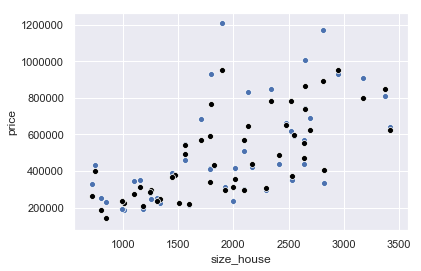

In [136]:
#Plotting the predictions
sns.scatterplot(df_test2['size_house'][0:50],df_test2['price'][0:50])
sns.scatterplot(df_test2['size_house'][0:50],GB_pred[0:50],color = 'black')

In [137]:
#Error (root mean squared)
error_GB = mean_squared_error(df_test2['price'],GB_pred)
np.sqrt(error_GB)

133106.0697336727

## Added on Nov 5

In [138]:
GB_pred_train = GBreg.predict(df_train2[['num_bed', 'num_bath', 'size_house', 'size_lot', 'is_waterfront', 'zip','avg_size_neighbor_houses', 'avg_size_neighbor_lot']])
error_GB_train = mean_squared_error(df_train2['price'],GB_pred_train)
np.sqrt(error_GB_train)

103648.39805821133

We see that the Gradient boosting has not performed better than the Random forest regressor.

## Conclusion and further remarks

In our analysis we first identified the most significant variables for price predictions and removed the columns that were of little use. We then use simple linear regressor to predict prices. We then used three different regression techniques to predict prices for sale of homes. These three in order of decreasing root mean squared errors are Decision Tree regressor, Gradient boosting Regressor and the Random forest regressor. The reason for choosing these three is that there are both numerical and categorical variables in the dataset and these ensemble based methods usually perform better when the two types of variables exist. 

I would further like to try to use stacking or averaging these models for better predictions. I would try weighted averages of models given their error outputs. One can also tweak the models using constraint parameters, for example min_leaves or max_depth in decision tree and random forest classfiers. These considerations will certainly improve the models. 